In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.opflow import PauliSumOp, AbelianGrouper
from qiskit.circuit.library import EfficientSU2

from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.algorithms.optimizers import SPSA

from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeBurlington
from qiskit import transpile, QuantumCircuit

from qiskit.providers.ibmq import IBMQ

import mthree

In [2]:
# load account
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='near-time')
provider = IBMQ.get_provider(hub='ibm-q', group='open')

In [4]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [5]:
# define backends
ibmq_qasm_backend = provider.get_backend('ibmq_qasm_simulator')
qasm_backend = QasmSimulator(shots=8192)
noisy_backend = FakeBurlington()
real_backend = provider.get_backend('ibmq_lima')

In [6]:
# select backend
backend = qasm_backend
# backend = noisy_backend
# backend = real_backend

# set number of shots
backend.shots = 8192

# 0. Circuit Sampling

In [7]:
def raw_sample(circuit, backend=backend, optimization_level=3):
    
    # transpile circuit
    qc = transpile(circuit, backend, optimization_level=optimization_level)
    
    # run circuit
    job = backend.run(qc)
    counts = job.result().get_counts()
    
    # evaluate probabilities
    shots = sum(counts.values())
    probabilities = {b: c/shots for b, c in counts.items()}
    return probabilities

In [8]:
# instantiate and calibrate mitigation scheme
mit = mthree.M3Mitigation(backend)
mit.cals_from_system()
# mit.cals_from_system(method='independent')  # use this to speed up noisy simulation
    
def mitigated_sample(circuit, backend=backend, mit=mit, optimization_level=3):
    
    # transpile circuit
    qc = transpile(circuit, backend, optimization_level=optimization_level)
    
    # determine final qubit mappings
    maps = mthree.utils.final_measurement_mapping(qc)
    
    # run circuit
    job = backend.run(qc)
    counts = job.result().get_counts()
        
    # mitigate shots
    quasi_probabilities = mit.apply_correction(counts, maps)    
    return quasi_probabilities

In [9]:
# choose sampling function
sample = raw_sample
# sample = mitigated_sample

In [10]:
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1, 2)
circuit.measure_all()
circuit.draw()

┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────────░─┤M├──────
        └───┘┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──■───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

In [11]:
# raw sampling without noise
raw_sample(circuit, qasm_backend)

{'000': 0.4952392578125, '111': 0.5047607421875}

In [12]:
# raw sampling with noise
raw_sample(circuit, backend)

{'000': 0.508544921875, '111': 0.491455078125}

In [13]:
# mitigating sampling with noise
mitigated_sample(circuit, backend)

{'000': 0.51220703125, '111': 0.48779296875}

# 1. Estimation of Expectation Values and VQE

### 1.1 Preliminaries
- `PauliSumOp`
- `AbelianGrouper`
- Deriving measurement bases

In [14]:
# define Hamiltonian
H = PauliSumOp.from_list([('XXI', 1), ('XII', 2), ('YIY', 3), ('ZZI', 4), ('XIY', 5)])

# second test Hamiltonian
# H = PauliSumOp.from_list([('ZZI', 1), ('ZII', 2), ('ZIZ', 3), ('IZZ', 4)])

print(H)

1.0 * XXI
+ 2.0 * XII
+ 3.0 * YIY
+ 4.0 * ZZI
+ 5.0 * XIY


In [15]:
# group commuting Pauli terms 
grouper = AbelianGrouper()
groups = grouper.convert(H)
print('-----------')
for group in groups.oplist:
    print(group)
    print('-----------')

-----------
3.0 * YIY
-----------
4.0 * ZZI
-----------
1.0 * XXI
+ 2.0 * XII
+ 5.0 * XIY
-----------


In [16]:
# derives measurement basis from group of commuting Pauli terms
for group in groups:
    basis = ['I']*group.num_qubits
    for pauli_string in group.primitive.paulis:
        for i, pauli in enumerate(pauli_string):
            p = str(pauli)
            if p != 'I':
                if basis[i] == 'I':
                    basis[i] = p
                elif basis[i] != p:
                    raise ValueError('PauliSumOp contains non-commuting terms!')
    print(basis)

['Y', 'I', 'Y']
['I', 'Z', 'Z']
['Y', 'X', 'X']


### 1.2 Estimator class

In [17]:
class Estimator():
    
    def __init__(self, observable, circuit, callback=None):
        """ Instantiate estimator for given observable and circuit. """
        
        # store problem
        self._observable = observable
        self._circuit = circuit
        
        # group Pauli terms
        self._grouper = AbelianGrouper()
        self._groups = self._grouper.convert(self._observable).oplist
        
        # derive measurement bases
        self._bases = []
        for group in self._groups:
            self._bases += [self._get_measurement_basis(group)]
            
        # construct circuits with post-rotations
        self._circuits = []
        for basis in self._bases:
            self._circuits += [self._append_post_rotation(self._circuit, basis)]
            
        # store callback
        self._callback = callback
        
    def _get_measurement_basis(self, observable):
        """ Derive measurement basis from observable or raise exception in case of non-commuting terms. """
                
        basis = ['I']*observable.num_qubits
        for pauli_string in observable.primitive.paulis:
            for i, pauli in enumerate(pauli_string):
                p = str(pauli)
                if p != 'I':
                    if basis[i] == 'I':
                        basis[i] = p
                    elif basis[i] != p:
                        raise ValueError('PauliSumOp contains non-commuting terms!')
        return basis
    
    def _append_post_rotation(self, circuit, basis):
        """ Append post rotation to circuit to measure in given basis. """
        
        new_circuit = circuit.copy()
        for i, pauli in enumerate(basis):
            if pauli == 'X':  # H @ X @ H = Z
                new_circuit.h(i)
            if pauli == 'Y':  # S^dag @ H @ Y @ H @ S = Z
                new_circuit.s(i)
                new_circuit.h(i)
        new_circuit.measure_all()
        return new_circuit
    
    def estimate(self, param_values=None):
        """ Estimate expectation value of given observable in state corresponding to given parameter values. """

        if param_values is None and self._circuit.num_parameters > 0 or\
            len(param_values) != self._circuit.num_parameters:
            raise ValueError('Wrong number of parameters!')
        
        value = 0        
        for group, circuit in zip(self._groups, self._circuits):
            value += self._estimate_group(group, circuit, param_values)        
            
        if self._callback:
            self._callback(np.real(value))
            
        return np.real(value)
        
    def _estimate_group(self, group, circuit, param_values):
        """ Estimate expectation value for group of commuting terms that can be measured in the same basis. """
        
        probabilities = sample(circuit.bind_parameters(param_values), backend)
        
        value = 0
        for (pauli, coeff) in zip(group.primitive.paulis, group.primitive.coeffs):
            val = 0
            p = str(pauli)
            for b, prob in probabilities.items():
                val += prob * np.prod([(-1)**(b[i] == '1' and p[i] != 'I') for i in range(len(b))])

            value += coeff * val
    
        return value

In [18]:
# define parametrized circuit
circuit = EfficientSU2(H.num_qubits, entanglement='linear', reps=1)
circuit.decompose().draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐             
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├─────────────
     ├──────────┤├──────────┤┌─┴─┐└──────────┘├──────────┤┌───────────┐
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤└───┘   ┌─┴─┐    ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├────────┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘        └───┘    └──────────┘└───────────┘

In [19]:
# instantiate estimator
estimator = Estimator(H, circuit, lambda x: print(f'objective = {x}'))

In [20]:
# test on random parameters
theta = np.random.rand(12)
estimator.estimate(theta)

objective = 2.81591796875


2.81591796875

### 1.3 Classical baseline

In [21]:
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(H)
print(exact_result)

{   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([ 0.18959355-0.1737214j ,  0.1737214 +0.18959355j,
              0.36238323-0.22924563j,  0.22924563+0.36238323j,
             -0.39861804+0.15804689j, -0.15804689-0.39861804j,
             -0.25203264+0.05103318j, -0.05103318-0.25203264j],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': -9.545916168529724}


### 1.4 Build custom VQE

In [22]:
# instantiate optimizer
optimizer = SPSA(maxiter=100)

In [23]:
x0 = np.random.rand(circuit.num_parameters)
result = optimizer.minimize(estimator.estimate, x0=x0)
print(result.fun)
print(result.x)

# store ground state parameters for later
ground_state_params = result.x

objective = 0.8662109375
objective = 2.041015625
objective = 3.355712890625
objective = 0.512939453125
objective = 3.417724609375
objective = 0.483154296875
objective = 1.283203125
objective = 2.457763671875
objective = 2.19677734375
objective = 1.1875
objective = 0.48046875
objective = 2.8828125
objective = 1.59228515625
objective = 1.906005859375
objective = -0.439453125
objective = 4.505615234375
objective = 3.107177734375
objective = 1.408447265625
objective = 2.228515625
objective = 1.65283203125
objective = 1.367919921875
objective = 2.698974609375
objective = 0.384033203125
objective = 2.772705078125
objective = 2.901611328125
objective = 1.0283203125
objective = 3.9306640625
objective = -0.978515625
objective = 3.153564453125
objective = 0.437255859375
objective = 0.354736328125
objective = 4.1455078125
objective = 3.872314453125
objective = 0.368896484375
objective = 2.80078125
objective = 1.643798828125
objective = 3.35205078125
objective = 1.058837890625
objective = 1.524658

### 1.5 Compare to Qiskit VQE

In [24]:
vqe = VQE(circuit, optimizer, quantum_instance=backend)

In [25]:
result = vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': {   '000': 0.31926276158910233,
                      '001': 0.23333100817293873,
                      '010': 0.18388441087405968,
                      '011': 0.47005027989035386,
                      '100': 0.40864677595693816,
                      '101': 0.5879652413195868,
                      '110': 0.2445699350390395,
                      '111': 0.12789613706050704},
    'eigenvalue': (-9.01904296875+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 2.3862855723409733,
                              ParameterVectorElement(θ[2]): -2.616350919853289,
                              ParameterVectorElement(θ[5]): 1.5367672116690385,
                              ParameterVectorElement(θ[7]): 2.131384713279394,
                              ParameterVectorElement(θ[4]): -3.1625847976687687,
                              ParameterVectorElement(θ[1]): 0.5098976574496583,
            

### 1.6 Integrate in Qiskit

Implement Qiskit's `MinimumEigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [26]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

class CustomVQE(MinimumEigensolver):
    
    def __init__(self, circuit, optimizer):
        self._circuit = circuit
        self._optimizer = optimizer
        
    def compute_minimum_eigenvalue(self, operator, aux_operators=None):
                
        # run optimization
        estimator = Estimator(operator, self._circuit)        
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(estimator.estimate, x0=x0)

        # evaluate auxilliary operators if given
        aux_operator_eigenvalues = None
        if aux_operators is not None:
            aux_operator_eigenvalues = []
            for aux_estimator in [ Estimator(aux_op, self._circuit) 
                                      for aux_op in aux_operators ]:
                aux_operator_eigenvalues += [aux_estimator.estimate(res.x)]
        
        # populate results
        result = VQEResult()
        result.aux_operator_eigenvalues = aux_operator_eigenvalues
        result.cost_function_evals = res.nfev
        result.eigenstate = None
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        result.optimal_point = res.x
        result.optimal_value = res.fun
        return result

In [27]:
custom_vqe = CustomVQE(circuit, optimizer)
result = custom_vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': None,
    'eigenvalue': -8.2919921875,
    'optimal_parameters': array([ 0.62496417,  0.09811446,  2.71615635,  1.20454321,  1.66634448,
        1.91517859, -1.46578312,  0.14232564,  0.90047419,  1.59898951,
        1.1291418 ,  0.05501152]),
    'optimal_point': array([ 0.62496417,  0.09811446,  2.71615635,  1.20454321,  1.66634448,
        1.91517859, -1.46578312,  0.14232564,  0.90047419,  1.59898951,
        1.1291418 ,  0.05501152]),
    'optimal_value': -8.2919921875,
    'optimizer_evals': None,
    'optimizer_time': None}


# 2. State Fidelity

In [28]:
class Fidelity():
    
    def __init__(self, circuit_1, circuit_2, callback=None):
        """ Instantiate fidelity estimator. """
        self._circuit_1 = circuit_1
        self._circuit_2 = circuit_2
        
        self._circuit_1.remove_final_measurements()
        self._circuit_2.remove_final_measurements()
        
        self._callback = callback
        
    def estimate(self, param_values_1, param_values_2):
        """ Estimate fidelity between the two states defined by 
        the given parameter values. """
        
        # bind parameter values and transpile circuit
        qc = self._circuit_1.bind_parameters(param_values_1)
        qc.append(self._circuit_2.bind_parameters(param_values_2).inverse(), 
                  range(self._circuit_2.num_qubits))
        qc.measure_all()
        
        # run circuit and get probabilities
        probabilities = sample(qc, backend)
        
        # estimate fidelity: |<0|U_1^dag U_2|0>|^2
        fidelity = np.minimum(1.0, np.maximum(0.0, probabilities.get('0'*qc.num_qubits, 0.0)))
        
        if self._callback:
            self._callback(fidelity)
        
        return fidelity

In [29]:
# instantiate fidelity
fidelity = Fidelity(circuit, circuit, lambda x: print(f'fidelity = {x}'))

In [30]:
# sample random parameters
x = np.random.rand(circuit.num_parameters)
y = np.random.rand(circuit.num_parameters)

In [31]:
# interpolation between parameters
ts = np.linspace(0, 1)
fidelities = []
for t in ts:
    fidelities += [fidelity.estimate(x, x + t*(y-x))]

fidelity = 1.0
fidelity = 0.999755859375
fidelity = 0.9989013671875
fidelity = 0.998046875
fidelity = 0.995849609375
fidelity = 0.9949951171875
fidelity = 0.9910888671875
fidelity = 0.9876708984375
fidelity = 0.9853515625
fidelity = 0.983642578125
fidelity = 0.9765625
fidelity = 0.97216796875
fidelity = 0.9678955078125
fidelity = 0.965087890625
fidelity = 0.957275390625
fidelity = 0.95263671875
fidelity = 0.9447021484375
fidelity = 0.9345703125
fidelity = 0.926513671875
fidelity = 0.9268798828125
fidelity = 0.9129638671875
fidelity = 0.9080810546875
fidelity = 0.9051513671875
fidelity = 0.892822265625
fidelity = 0.8792724609375
fidelity = 0.871826171875
fidelity = 0.8680419921875
fidelity = 0.8536376953125
fidelity = 0.853271484375
fidelity = 0.8333740234375
fidelity = 0.8214111328125
fidelity = 0.8109130859375
fidelity = 0.8057861328125
fidelity = 0.7947998046875
fidelity = 0.79150390625
fidelity = 0.776123046875
fidelity = 0.76171875
fidelity = 0.7569580078125
fidelity = 0.7414550781

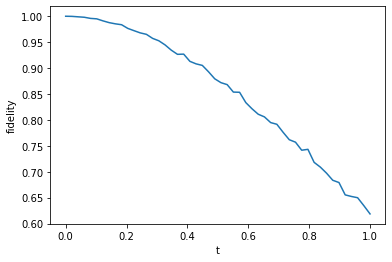

In [32]:
plt.plot(ts, fidelities)
plt.xlabel('t')
plt.ylabel('fidelity')
plt.show()

# 3. Variational Quantum Deflation (VQD)
https://arxiv.org/abs/1805.08138

### 3.1 Classical Baseline

In [33]:
exact_solver = NumPyEigensolver(k=2)
exact_result = exact_solver.compute_eigenvalues(H)
print(exact_result)

{   'aux_operator_eigenvalues': None,
    'eigenstates': ListOp([VectorStateFn(Statevector([-0.25227021+0.04984556j, -0.04984556-0.25227021j,
             -0.42874187+0.00745489j, -0.00745489-0.42874187j,
              0.42268399+0.07220391j, -0.07220391+0.42268399j,
              0.2418314 +0.08742087j, -0.08742087+0.2418314j ],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False), VectorStateFn(Statevector([ 0.13058298-0.22553789j,  0.22553789+0.13058298j,
             -0.28918099+0.31377556j, -0.31377556-0.28918099j,
             -0.3543427 +0.23774356j, -0.23774356-0.3543427j ,
              0.24286831-0.09452109j,  0.09452109+0.24286831j],
            dims=(2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-9.54591617, -7.6730362 ])}


### 3.2 Define VQD Objective

In [34]:
# set penalty weight for overlap term
penalty = 25

# define objective for VQD
def vqd_objective(param_values, 
                  energy=estimator.estimate, 
                  overlap=lambda x: fidelity.estimate(x, ground_state_params),
                  penalty=penalty):

    value = energy(param_values)
    value += penalty * overlap(param_values)
    return value

### 3.3 Run VQD

In [35]:
# run optimization to get first excited state
result = optimizer.minimize(vqd_objective, np.random.rand(circuit.num_parameters))
print(result)

objective = 2.688720703125
fidelity = 0.0921630859375
objective = 3.854736328125
fidelity = 0.0106201171875
objective = 3.653564453125
fidelity = 0.0177001953125
objective = 2.507080078125
fidelity = 0.104248046875
objective = 3.170654296875
fidelity = 0.041748046875
objective = 3.759521484375
fidelity = 0.076416015625
objective = 3.271240234375
fidelity = 0.081298828125
objective = 3.19140625
fidelity = 0.0284423828125
objective = 2.62841796875
fidelity = 0.126220703125
objective = 3.9853515625
fidelity = 0.0189208984375
objective = 3.92578125
fidelity = 0.067626953125
objective = 1.67041015625
fidelity = 0.0911865234375
objective = 3.87255859375
fidelity = 0.0552978515625
objective = 2.2265625
fidelity = 0.0726318359375
objective = 3.61181640625
fidelity = 0.063720703125
objective = 3.560302734375
fidelity = 0.0782470703125
objective = 3.051513671875
fidelity = 0.0926513671875
objective = 3.750732421875
fidelity = 0.0379638671875
objective = 3.021240234375
fidelity = 0.102783203125
o

objective = -7.621826171875
fidelity = 0.0230712890625
objective = -7.113525390625
fidelity = 0.01123046875
objective = -7.44140625
fidelity = 0.004638671875
objective = -7.35693359375
fidelity = 0.0074462890625
objective = -7.3056640625
fidelity = 0.0003662109375
objective = -7.037353515625
fidelity = 0.01806640625
objective = -7.61376953125
fidelity = 0.000732421875
objective = -7.0751953125
fidelity = 0.003173828125
objective = -7.223876953125
fidelity = 0.003662109375
objective = -7.520751953125
fidelity = 0.0218505859375
objective = -7.331787109375
fidelity = 0.015380859375
objective = -7.292724609375
fidelity = 0.0042724609375
objective = -6.9443359375
fidelity = 0.002685546875
objective = -7.634765625
fidelity = 0.0123291015625
objective = -7.682373046875
fidelity = 0.009765625
objective = -7.155029296875
fidelity = 0.021484375
objective = -7.485107421875
fidelity = 0.018310546875
objective = -6.968994140625
fidelity = 0.0335693359375
objective = -7.217529296875
fidelity = 0.000

In [36]:
# determine energy
estimator.estimate(result.x)

# determine overlap with ground state
fidelity.estimate(result.x, ground_state_params);

objective = -8.044921875
fidelity = 0.0010986328125


### Integrate into Qiskit

Implement Qiskit's `Eigensolver` interface to reuse custom algorithm in Qiskit Applications stack.

In [37]:
from qiskit.algorithms import Eigensolver, EigensolverResult

class VQD(Eigensolver):
    
    def __init__(self, circuit, optimizer):
        self._circuit = circuit
        self._optimizer = optimizer
        
    def compute_eigenvalues(self, operator, aux_operators=None):
        
        # setup estimators
        estimator = Estimator(operator, self._circuit)
        fidelity = Fidelity(self._circuit, self._circuit)
        
        # compute groundstate
        vqe = CustomVQE(self._circuit, self._optimizer)
        vqe_result = vqe.compute_minimum_eigenvalue(operator)
        
        # compute first excited states
        objective = lambda x: vqd_objective(x, estimator.estimate, 
                                            lambda y: fidelity.estimate(y, vqe_result.optimal_parameters))
        
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(objective, x0)
                
        # populate results
        result = EigensolverResult()
        result.eigenvalues = [vqe_result.eigenvalue, res.fun]        
        return result        

In [38]:
vqd = VQD(circuit, optimizer)
result = vqd.compute_eigenvalues(H)
print(result)

{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [-8.88525390625, -5.816650390625]}


# 4. Outlook: Quantum Computational Primitives

- We will move towards quantum computational primitives, powered by Qiskit Runtime, e.g., for sampling, estimation, etc.
- These will encapsulate error mitigation and other features to improve the ease of use.
- The complete Qiskit Algorithms & Applications stack will be extended accordingly over 2022.